In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
workDir = '/home/chantal/Chazy/Bulk/ITS/data/'
figDir = '/home/chantal/Chazy/Bulk/ITS/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/ITS/'
physeqBulk = 'bulk-core'


nprocs = 20

In [4]:
%%R
library(phyloseq)
library(tidyr)
library(plyr); library(dplyr)
library(DESeq2)
library(foreach)
library(doParallel)
library(ggplot2)
library(gridExtra)
library(reshape2)
library(RColorBrewer)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/f

#### Read in sample metadata and OTU table

In [5]:
%%R

F = file.path(physeqDir, physeqBulk)
print(F)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS" & !(is.na(physeq.Bulk.m$Soil_Moisture))),
                           physeq.Bulk)
physeq.Bulk.m = physeq.Bulk %>% sample_data


physeq.Bulk = prune_samples((physeq.Bulk.m$Soil_Moisture != 50),
                           physeq.Bulk)

physeq.Bulk = subset_taxa(physeq.Bulk, Rank1=="k__Fungi")

physeq.Bulk.m = physeq.Bulk %>% sample_data


physeq.Bulk

[1] "/home/chantal/Chazy/data/phyloseq/ITS//bulk-core"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2247 taxa and 157 samples ]
sample_data() Sample Data:       [ 157 samples by 24 sample variables ]
tax_table()   Taxonomy Table:    [ 2247 taxa by 7 taxonomic ranks ]


In [9]:
%%R
get_l2fc = function(physeq.obj, sparsity_threshold) {
  
    physeq.Bulk.m = physeq.obj %>% sample_data

    
    p = filter_taxa(physeq.obj, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
 
    dds = phyloseq_to_deseq2(p, ~ Soil_Moisture)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
        
    theta = 1
    r = results(dds, independentFiltering = FALSE)
    r$OTU = rownames(r)
   
    d = data.frame(r[, c("OTU","log2FoldChange", "lfcSE", "padj")])

   # d$padj = p.adjust(p, method = "BH")
    TT = data.frame(tax_table(p))
    TT$OTU = rownames(TT)
    d = left_join(d, TT)


    d
}
                    
                  

In [7]:
%%R
# adding range of sparsity thresholds (all pairwise)

sdms = as.data.frame(seq(0.05,0.95,0.05))
colnames(sdms) = 'sparsity_threshold'
#cat('Number of pairwise combinations of variables:', sdms.P %>% nrow, '\n\n')
head(sdms) 

  sparsity_threshold
1               0.05
2               0.10
3               0.15
4               0.20
5               0.25
6               0.30


In [10]:
%%R
registerDoParallel(8)

df.l2fc = tbl_df(mdply(sdms, 
                       get_l2fc, 
                       .parallel = TRUE, 
                       physeq.obj = physeq.Bulk))
df.l2fc

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: converting counts to integer mode

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:1

Source: local data frame [3,710 x 12]

   sparsity_threshold       OTU log2FoldChange     lfcSE      padj    Rank1
                (dbl)     (chr)          (dbl)     (dbl)     (dbl)   (fctr)
1                0.05  OTU.6089     0.15500954 0.1170900 0.4825623 k__Fungi
2                0.05  OTU.6711     0.06767550 0.1063355 0.7596121 k__Fungi
3                0.05  OTU.2605    -0.15764375 0.0814035 0.2308435 k__Fungi
4                0.05 OTU.17326     0.03649937 0.1218708 0.8913579 k__Fungi
5                0.05 OTU.14908     0.32276639 0.1281211 0.1102420 k__Fungi
6                0.05  OTU.6041    -0.03842030 0.1188705 0.8865105 k__Fungi
7                0.05  OTU.6291    -0.02768458 0.1002886 0.8985001 k__Fungi
8                0.05  OTU.9364     0.21095358 0.1120892 0.2474305 k__Fungi
9                0.05   OTU.586    -0.08455365 0.0841519 0.6121372 k__Fungi
10               0.05 OTU.19007     0.24475250 0.1243356 0.2308435 k__Fungi
..                ...       ...            ...   

In [11]:
%%R
summarise(df.l2fc,
  meanl2fc = mean(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

     meanl2fc
        (dbl)
1 -0.02541513


In [12]:
%%R
summarise(df.l2fc,
  sdl2fc = sd(log2FoldChange, na.rm = TRUE))

Source: local data frame [1 x 1]

    sdl2fc
     (dbl)
1 0.149242


In [13]:
%%R
df.l2fc$padj2 = p.adjust(df.l2fc$padj, method = "BH")

In [14]:
%%R
df.l2fc$Temp[df.l2fc$log2FoldChange > 0] = "increasing"
df.l2fc$Temp[df.l2fc$log2FoldChange <0] = "decreasing"

In [15]:
%%R
write.table(df.l2fc, "data/l2fc_MoistCompiled_noLM", row.names = FALSE, sep = ",")

In [16]:
%%R
df.l2fc = read.table('data/l2fc_MoistCompiled_noLM', sep =',', header = TRUE)

In [17]:
%%R
head(df.l2fc)

  sparsity_threshold       OTU log2FoldChange     lfcSE      padj    Rank1
1               0.05  OTU.6089     0.15500954 0.1170900 0.4825623 k__Fungi
2               0.05  OTU.6711     0.06767550 0.1063355 0.7596121 k__Fungi
3               0.05  OTU.2605    -0.15764375 0.0814035 0.2308435 k__Fungi
4               0.05 OTU.17326     0.03649937 0.1218708 0.8913579 k__Fungi
5               0.05 OTU.14908     0.32276639 0.1281211 0.1102420 k__Fungi
6               0.05  OTU.6041    -0.03842030 0.1188705 0.8865105 k__Fungi
             Rank2             Rank3           Rank4              Rank5
1  p__unidentified   c__unidentified o__unidentified    f__unidentified
2  p__unidentified   c__unidentified o__unidentified    f__unidentified
3  p__unidentified   c__unidentified o__unidentified    f__unidentified
4 p__Basidiomycota c__Agaricomycetes    o__Boletales f__Boletinellaceae
5 p__Basidiomycota c__Agaricomycetes   o__Agaricales    f__Bolbitiaceae
6 p__Basidiomycota c__Agaricomycetes   o__A

In [18]:
%%R
r = filter(df.l2fc, padj2 <=0.10)
print(length(unique(r$OTU)))
print(length(df.l2fc$OTU))

[1] 46
[1] 3710


In [21]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH.s = df.l2fc %>%
    filter(padj2 < padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH.s %>%  head

Source: local data frame [6 x 2]

  sparsity_threshold n_reject_hypo
               (dbl)         (int)
1               0.05            37
2               0.10            39
3               0.15            38
4               0.20            40
5               0.25            41
6               0.30            35


In [22]:
%%R
# max number of rejected hypos 
max.rejH = df.l2fc.rejH.s %>%
    arrange(desc(n_reject_hypo)) %>%
    head(n=1)
max.rejH = max.rejH$sparsity_threshold
max.rejH

[1] 0.25


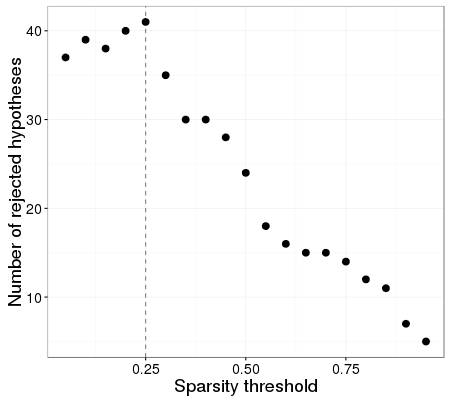

In [24]:
%%R -w 450 -h 400

ggplot(df.l2fc.rejH.s, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(size=3) +
    geom_vline(xintercept=max.rejH, linetype='dashed', alpha=0.5) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        )

In [27]:
%%R
df.l2fc.f = df.l2fc %>%
    filter(sparsity_threshold == 0.05) 

df.l2fc.f %>% nrow

[1] 748


In [28]:
%%R
length(unique(df.l2fc$OTU))

[1] 748


In [29]:
%%R #-i workDir
# Writing out l2fc table

outFile = 'data/l2fc_ Moist_allSamples_noLM.txt'
write.table(df.l2fc.f, 'data/l2fc_Moist_allSamples_noLM.txt', sep='\t', quote=FALSE, row.names=FALSE)

In [34]:
%%R
df.l2fc = read.table('data/l2fc_Moist_allSamples_noLM.txt', sep='\t', header = TRUE)

In [35]:
%%R
df.l2fc$Rank2 = gsub("p__", "", df.l2fc$Rank2)
df.l2fc$Rank3 = gsub("c__", "", df.l2fc$Rank3)
df.l2fc$Rank4 = gsub("o__", "", df.l2fc$Rank4)
df.l2fc$Rank5 = gsub("f__", "", df.l2fc$Rank5)
df.l2fc$Rank6 = gsub("g__", "", df.l2fc$Rank6)
df.l2fc$Rank7 = gsub("s__", "", df.l2fc$Rank7)

In [36]:
%%R
print(length(df.l2fc$OTU))
print(length(unique(df.l2fc$OTU)))

[1] 748
[1] 748


In [37]:
%%R
resp = df.l2fc %>% filter(padj2 <=0.10) %>% group_by(Temp) %>% summarise(resp = n()) 
resp$Temp = NULL
print(resp %>% as.data.frame)



  resp
1   23
2   14


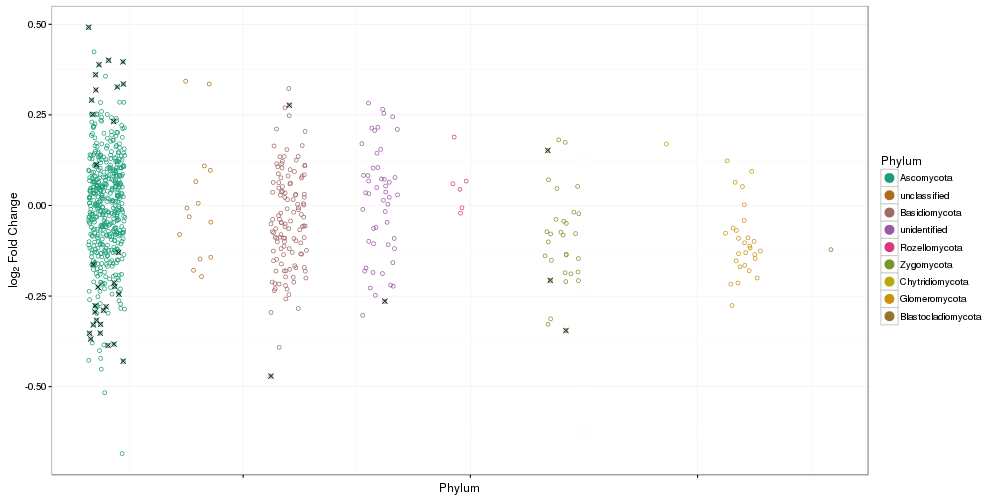

In [39]:
%%R -w 1000 -h 500
d = df.l2fc
FDR = 0.10

d$Rank2 = as.character(d$Rank2)
d$Rank2[is.na(d$Rank2)] = "unclassified"
d$Rank2 = factor(d$Rank2)

max.l2fc = ddply(d, .(Rank2), summarize, M = max(log2FoldChange))
d$Rank2 = factor(d$Rank2, max.l2fc[order(-max.l2fc$M),]$Rank2)

M = max(as.numeric(d$Rank2), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank2)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank2)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank2))

p = p + geom_point(alpha = 1.00, shape = 21, size = 1.5)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj2 <= FDR), color = "black", shape = 4, size = 2)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Phylum", color = "Phylum")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4, shape = 19)))

p

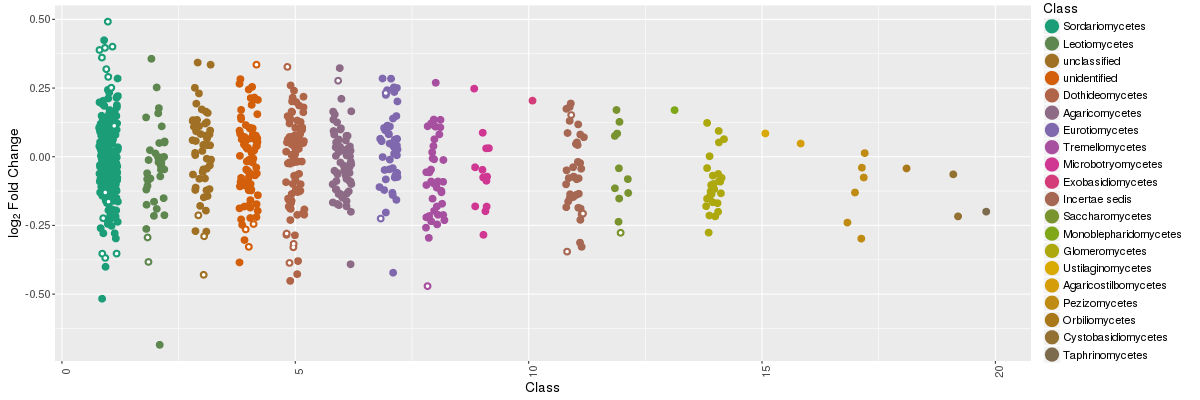

In [41]:
%%R -w 1200 -h 400
d = df.l2fc
FDR = 0.10

d$Rank3 = as.character(d$Rank3)
d$Rank3[is.na(d$Rank3)] = "unclassified"
d$Rank3 = factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank3 = factor(d$Rank3, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2

colourCount = length(unique(d$Rank3)) + 1
getPalette = colorRampPalette(brewer.pal(10, "Dark2"))

p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, color = Rank3))


p = p + geom_point(alpha = 1.00, shape = 19, size = 3)

p = p + scale_color_manual(values = getPalette(colourCount))

p = p + geom_point(data = subset(d, padj2 <= FDR), color = "white", shape = 19, size = 1)

#p = p + geom_hline(y = 1.3)

#p = p + theme_bw()

p = p + labs(x = "Class", color = "Class")

p = p + guides(col = guide_legend(ncol = 2))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=6))) +
        theme(text = element_text(size=14), axis.text.x = element_text(angle=90, vjust=1)) 


p

In [29]:
%%R
resp = df.l2fc %>% filter(padj2 <=0.10) %>% ungroup %>% group_by(Temp, Rank3, Rank2, Land_Management) %>% summarise(resp = n())
resp %>% as.data.frame

         Temp           Rank3         Rank2 Land_Management resp
1  decreasing Dothideomycetes    Ascomycota             NTH    1
2  decreasing Dothideomycetes    Ascomycota             NTR    1
3  decreasing Dothideomycetes    Ascomycota             PTR    1
4  decreasing  Eurotiomycetes    Ascomycota             NTH    1
5  decreasing   Leotiomycetes    Ascomycota             NTH    2
6  decreasing   Leotiomycetes    Ascomycota             NTR    1
7  decreasing   Leotiomycetes    Ascomycota             PTR    1
8  decreasing Sordariomycetes    Ascomycota             NTH    3
9  decreasing Sordariomycetes    Ascomycota             PTH    1
10 decreasing Sordariomycetes    Ascomycota             PTR    2
11 decreasing Tremellomycetes Basidiomycota             NTR    1
12 decreasing Tremellomycetes Basidiomycota             PTH    1
13 decreasing    unidentified    Ascomycota             NTH    1
14 decreasing    unidentified  unidentified             NTH    1
15 decreasing    unidenti

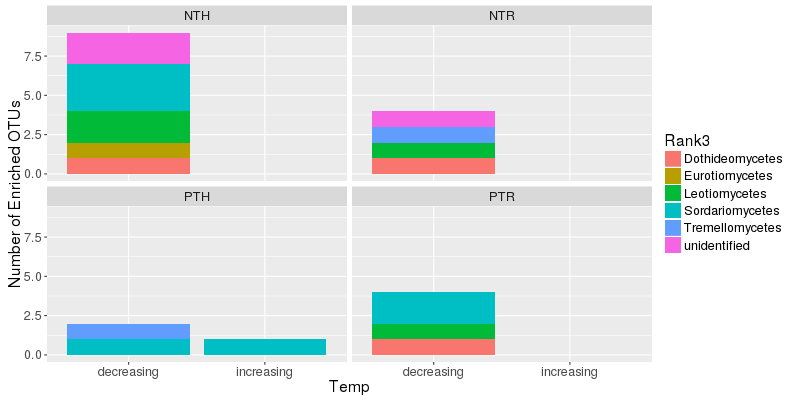

In [30]:
%%R -w 800 -h 400
p = ggplot(data = resp, aes(x = Temp, y = resp, fill = Rank3)) +
    geom_bar(stat = 'identity') + facet_wrap(~Land_Management) +
    theme(text = element_text(size=16)) + ylab("Number of Enriched OTUs") 
p

In [31]:
%%R
ggsave(filename = "data/figs/EnrichedNumoverTime.jpg", plot = p, width =12, height =6)

####Function arguments

In [32]:
%%R
colors.1 = c("#DA21B8",
"#86F84F",
"#B962F1",
"#7BCB03",
"#984BCF",
"#AFF13D",
"#BB1DB0",
"#4AB600",
"#EC60CF",
"#21B834",
"#AD0188",
"#BCD810",
"#2C4DB0",
"#98C815",
"#503B9E",
"#E1F957",
"#5A8DF8",
"#FD1300",
"#4EA6F4",
"#E93912",
"#68B5F3",
"#B4060B",
"#35D66F",
"#F82573",
"#73F28E",
"#FD1F54",
"#38C67A",
"#D02675",
"#A5F97D",
"#76328B",
"#98BE12",
"#9E88EB",
"#CEBF24",
"#3B3687",
"#E2A205",
"#2C73C3",
"#F7811F",
"#49AFDE",
"#D01C32",
"#0DC593",
"#F23D4F",
"#7DF5CB",
"#8D0506",
"#44C0AC",
"#F3643A",
"#09457F",
"#EDD65D",
"#DA92F0",
"#2AA142",
"#EB6CAD",
"#5F8F1A",
"#DF9ADA",
"#367220",
"#FF87A9",
"#22A470",
"#B12048",
"#C7F38C",
"#1D2151",
"#F0DE7C",
"#57265E",
"#EAF59D",
"#7D225C",
"#96E9B9",
"#F25E47",
"#1C739E",
"#B24E15",
"#DBF2FC",
"#4C1A07",
"#C4F4E7",
"#7C223D",
"#CEF7C5",
"#331B2D",
"#EEAA53",
"#1E3145",
"#FC966D",
"#0B2B05",
"#C4B0E7",
"#898E24",
"#F7D1E8",
"#2D3500",
"#F8847D",
"#114625",
"#F5AD9B",
"#205C39",
"#EDB374",
"#234F4A",
"#8F4918",
"#388C79",
"#796619",
"#513F0C",
"#5C6406",
"#93FB3B",
"#8C166F",
"#3CF397",
"#F63923",
"#2BFBD8",
"#B50F34",
"#7AF0EB",
"#D66E00",
"#579EFB",
"#A4CF32",
"#3E69C7",
"#E4F27B",
"#191D3B",
"#B2F8AB",
"#191D3B",
"#B2F8AB",
"#F15976",
"#38801A",
"#EE8BD6",
"#555415",
"#2F93C9",
"#EF8786",
"#142010",
"#F075AB",
"#0E4442",
"#F1B69C",
"#28507C",
"#CDCDE8")

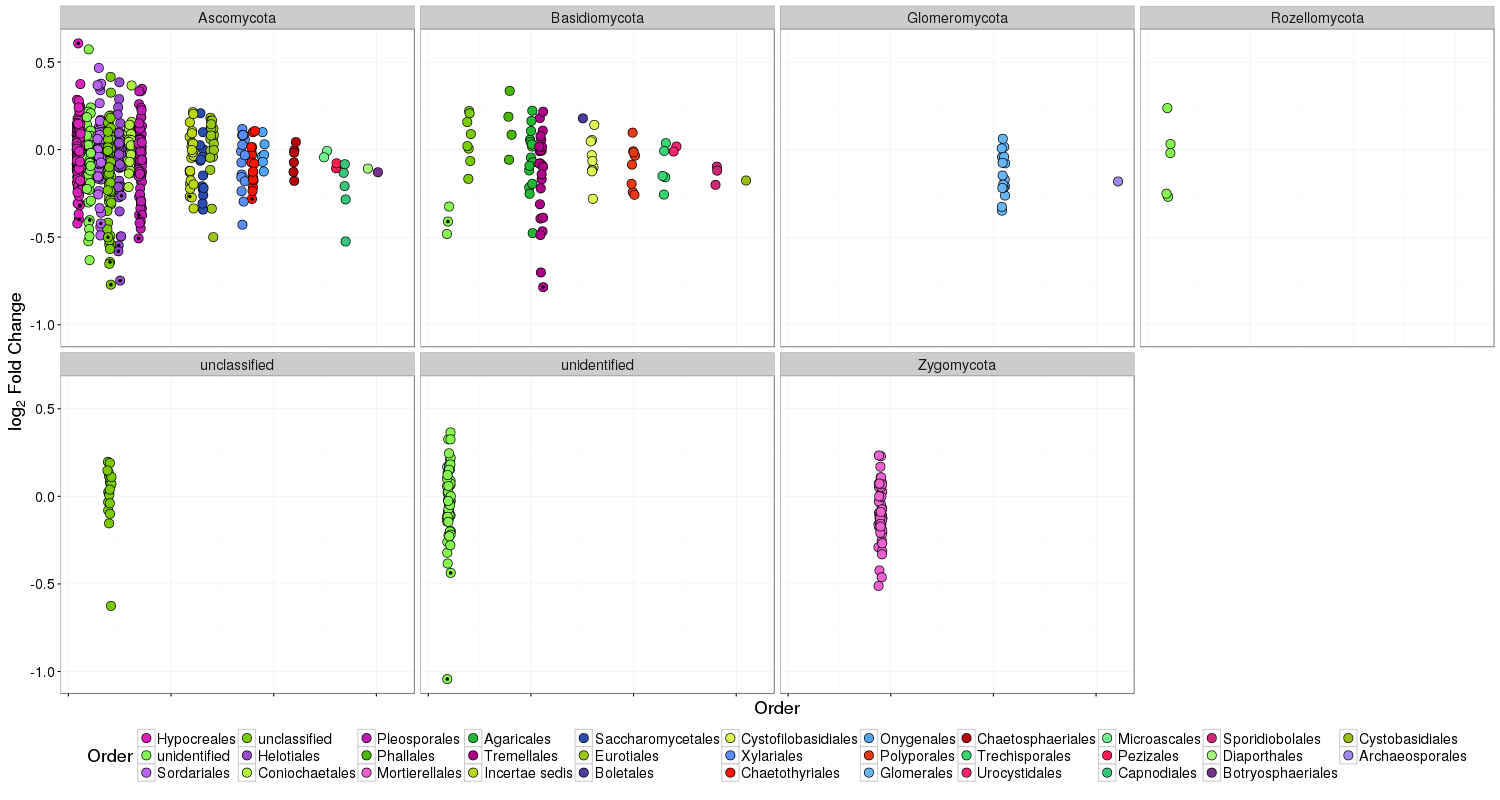

In [33]:
%%R -w 1500 -h 800
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi')
d$Rank4 = as.character(d$Rank4)
d$Rank4[is.na(d$Rank4)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank4)

max.l2fc = ddply(d, .(Rank4), summarize, M = max(log2FoldChange))
d$Rank4 = factor(d$Rank4, max.l2fc[order(-max.l2fc$M),]$Rank4)

M = max(as.numeric(d$Rank4), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank4)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank4))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Order", fill = "Order")

p = p + guides(fill = guide_legend(nrow = 3))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=18)) #+ guides(color = FALSE)

p = p + facet_wrap(~Rank2, ncol = 4) +
    theme(legend.position = 'bottom')

p

In [34]:
%%R
head(df.l2fc)

  Land_Management sparsity_threshold       OTU log2FoldChange      lfcSE
1             NTH                0.3   OTU.586    -0.27693388 0.12382706
2             NTH                0.3  OTU.1470     0.05747517 0.10478369
3             NTH                0.3   OTU.133    -0.01959796 0.06337634
4             NTH                0.3    OTU.45    -0.03424437 0.06585826
5             NTH                0.3  OTU.2583    -0.21611678 0.12034139
6             NTH                0.3 OTU.87670    -0.29031755 0.13302698
       padj    Rank1         Rank2           Rank3          Rank4
1 0.1139483 k__Fungi    Ascomycota Dothideomycetes           <NA>
2 0.8077015 k__Fungi Basidiomycota  Agaricomycetes     Agaricales
3 0.8965164 k__Fungi    Ascomycota Sordariomycetes    Hypocreales
4 0.8217570 k__Fungi Basidiomycota  Agaricomycetes    Polyporales
5 0.2270071 k__Fungi Basidiomycota  Agaricomycetes     Agaricales
6 0.1231637 k__Fungi    Zygomycota  Incertae sedis Mortierellales
            Rank5       Ran

In [35]:
%%R
df.P = df.l2fc %>% group_by(Rank2) %>% mutate(ntax = n()) %>% filter(padj2 <= 0.10) %>% mutate(resp = n()) 
head(df.P)

Source: local data frame [6 x 17]
Groups: Rank2 [1]

  Land_Management sparsity_threshold     OTU log2FoldChange      lfcSE
           (fctr)              (dbl)  (fctr)          (dbl)      (dbl)
1             NTH                0.3 OTU.134     -0.2815358 0.06819462
2             NTH                0.3  OTU.60     -0.4027948 0.06714768
3             NTH                0.3 OTU.114     -0.3983688 0.10068074
4             NTH                0.3 OTU.197     -0.7475405 0.11985685
5             NTH                0.3 OTU.785     -0.6417862 0.12611153
6             NTH                0.3  OTU.58     -0.2679471 0.06760129
Variables not shown: padj (dbl), Rank1 (fctr), Rank2 (chr), Rank3 (chr), Rank4
  (chr), Rank5 (chr), Rank6 (chr), Rank7 (chr), padj2 (dbl), Temp (fctr), ntax
  (int), resp (int)


In [36]:
%%R
df.P2 = df.P %>% ungroup %>% select(Rank2, ntax, resp) %>% unique() 
df.P2$Perc_resp = df.P2$resp/df.P2$ntax

df.P2 %>% arrange(Rank2)

Source: local data frame [3 x 4]

          Rank2  ntax  resp  Perc_resp
          (chr) (int) (int)      (dbl)
1    Ascomycota   684    16 0.02339181
2 Basidiomycota    83     2 0.02409639
3  unidentified    57     2 0.03508772


In [37]:
%%R
df.P2 = df.P %>% ungroup %>% select(Rank2, ntax, resp) %>% unique() 
df.P2$Perc_respoftotal = df.P2$resp/sum(df.P2$resp)

df.P2 %>% arrange(Rank2)

Source: local data frame [3 x 4]

          Rank2  ntax  resp Perc_respoftotal
          (chr) (int) (int)            (dbl)
1    Ascomycota   684    16              0.8
2 Basidiomycota    83     2              0.1
3  unidentified    57     2              0.1


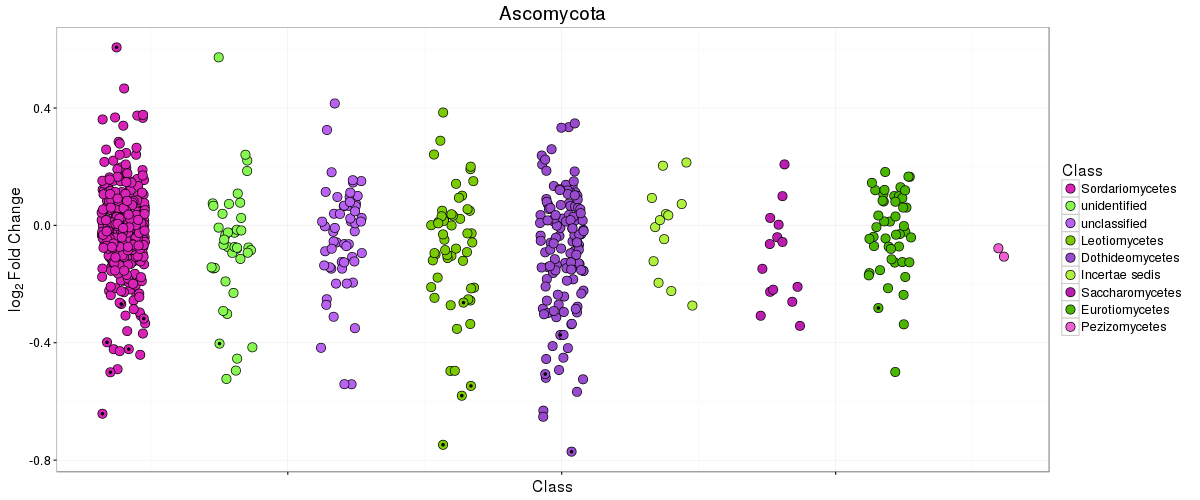

In [38]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Ascomycota')
d$Rank3 = as.character(d$Rank3)
d$Rank3[is.na(d$Rank3)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank3 = factor(d$Rank3, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank3))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Class", fill = "Class")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle('Ascomycota')


p

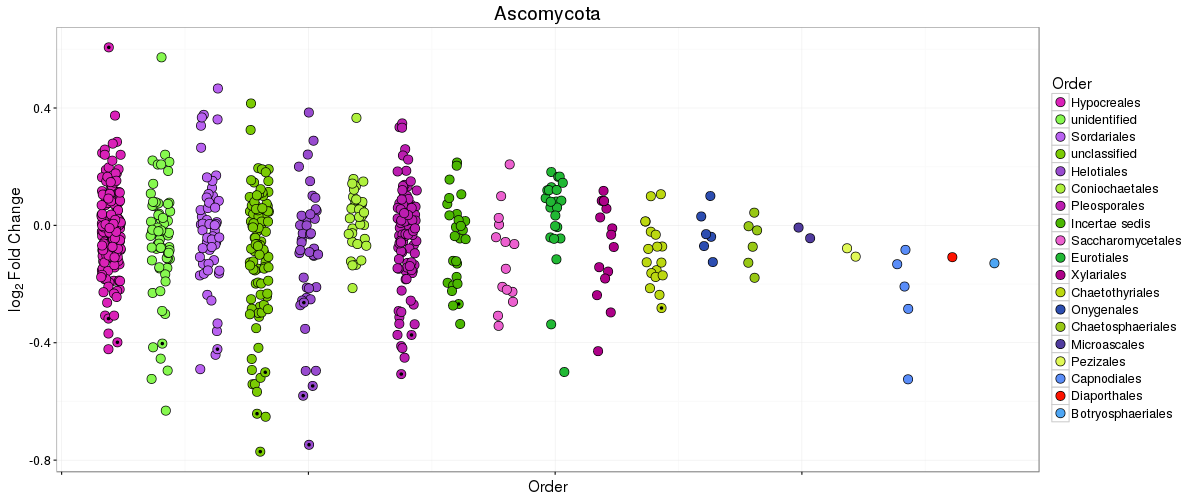

In [39]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Ascomycota')
d$Rank4 = as.character(d$Rank4)
d$Rank4[is.na(d$Rank4)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank4)

max.l2fc = ddply(d, .(Rank4), summarize, M = max(log2FoldChange))
d$Rank4 = factor(d$Rank4, max.l2fc[order(-max.l2fc$M),]$Rank4)

M = max(as.numeric(d$Rank4), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank4)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank4))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Order", fill = "Order")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle('Ascomycota')


p

In [40]:
%%R
test = d %>% group_by(Rank4) %>% filter(padj2 <=0.10) %>% mutate(ntax = n()) %>% group_by(Rank4, Till, ntax) %>%
        summarise(resp = n()) 

test = test %>% select(Rank4, Till, resp, ntax)
test$total = (test$resp/test$ntax)
test %>% as.data.frame


Error in eval(expr, envir, enclos) : unknown column 'Till'


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : unknown column 'Till'

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning messages:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: replacing previous import ‘BiocGenerics::Position’ by ‘ggplot2::Position’ when loading ‘phyloseq’ 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy

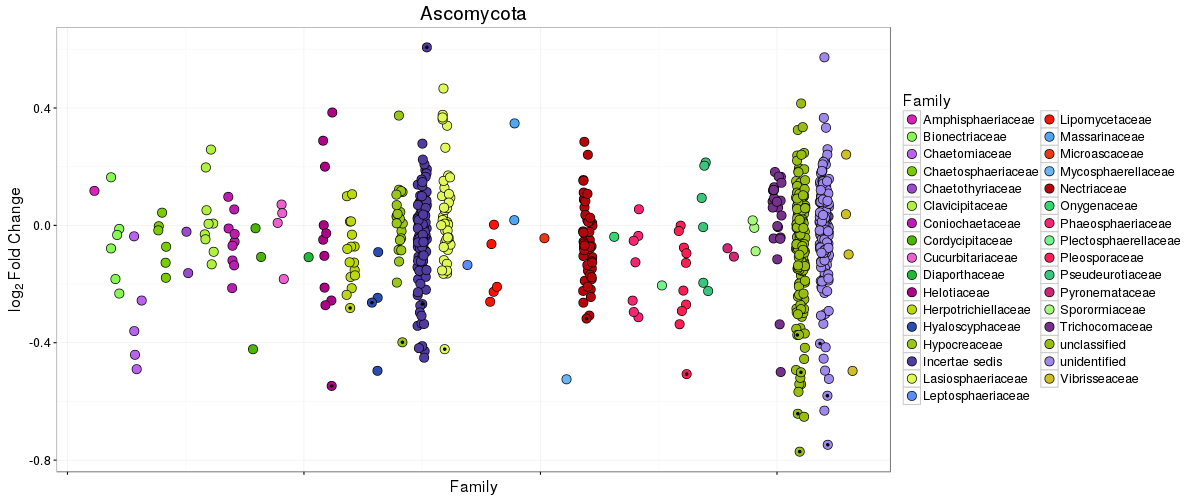

In [41]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Ascomycota')
d$Rank5 = as.character(d$Rank5)
d$Rank5[is.na(d$Rank5)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank5= factor(d$Rank5)

max.l2fc = ddply(d, .(Rank5), summarize, M = max(log2FoldChange))
d$Rank4 = factor(d$Rank5, max.l2fc[order(-max.l2fc$M),]$Rank5)

M = max(as.numeric(d$Rank5), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank5)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank5))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Family", fill = "Family")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle('Ascomycota')


p

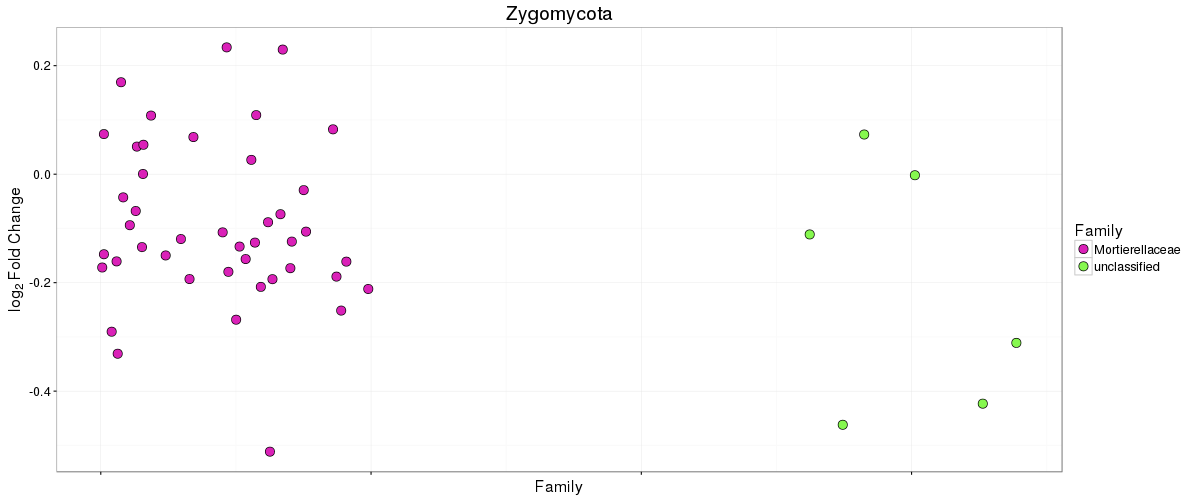

In [42]:
%%R -w 1200 -h 500
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Zygomycota')
d$Rank5 = as.character(d$Rank5)
d$Rank5[is.na(d$Rank5)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank5= factor(d$Rank5)

max.l2fc = ddply(d, .(Rank5), summarize, M = max(log2FoldChange))
d$Rank4 = factor(d$Rank5, max.l2fc[order(-max.l2fc$M),]$Rank5)

M = max(as.numeric(d$Rank5), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank5)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank5))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Family", fill = "Family")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle('Zygomycota')


p

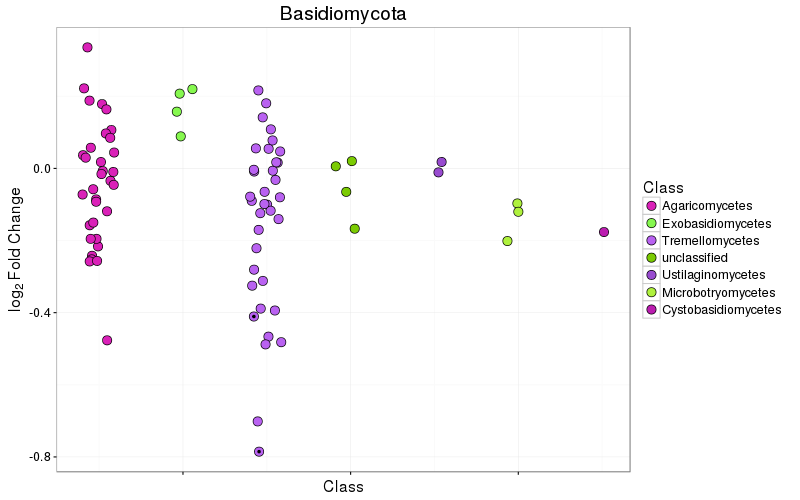

In [43]:
%%R -w 800 -h 500
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Basidiomycota')
d$Rank3 = as.character(d$Rank3)
d$Rank3[is.na(d$Rank3)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank3)

max.l2fc = ddply(d, .(Rank3), summarize, M = max(log2FoldChange))
d$Rank3 = factor(d$Rank3, max.l2fc[order(-max.l2fc$M),]$Rank3)

M = max(as.numeric(d$Rank3), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank3)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank3))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Class", fill = "Class")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle('Basidiomycota')


p

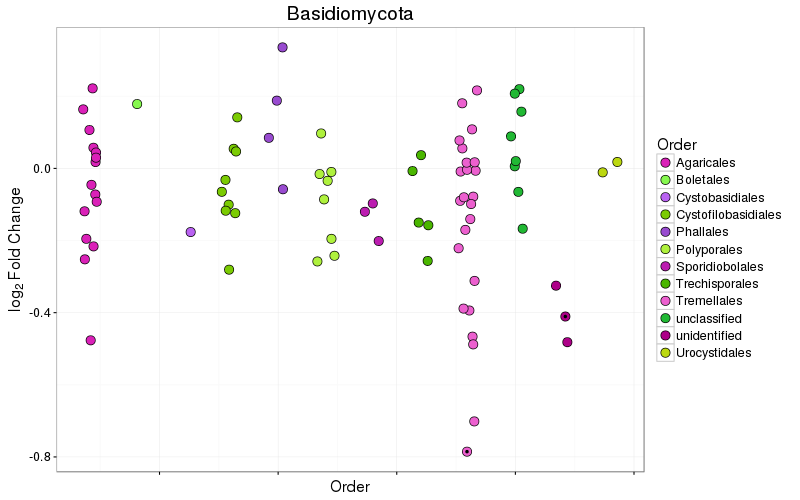

In [44]:
%%R -w 800 -h 500
d = df.l2fc
FDR = 0.10

d = filter(d, Rank1 == 'k__Fungi', Rank2 == 'Basidiomycota')
d$Rank4 = as.character(d$Rank4)
d$Rank4[is.na(d$Rank4)] = "unclassified"
d$Rank2[is.na(d$Rank2)] = "unclassified"

d$Rank4= factor(d$Rank4)

max.l2fc = ddply(d, .(Rank4), summarize, M = max(log2FoldChange))
d$Rank3 = factor(d$Rank4, max.l2fc[order(-max.l2fc$M),]$Rank4)

M = max(as.numeric(d$Rank4), na.rm = TRUE) + 1
d$x = as.numeric(d$Rank4)
d$x[is.na(d$x)] = M
d$x.jitter = d$x + runif(length(d$x), -1, 1) * 0.2


p = ggplot(d, aes(x = x.jitter, y = log2FoldChange, fill = Rank4))

p = p + geom_point(alpha = 1.00, shape = 21, size = 4)

p = p + scale_fill_manual(values = colors.1)

p = p + geom_point(data = subset(d, padj2 <= 0.10), fill = "black", shape = 21, size = 1)

#p = p + geom_hline(y = 1.3)

p = p + theme_bw()

p = p + theme(axis.text.x = element_blank())

p = p + labs(x = "Order", fill = "Order")

p = p + guides(col = guide_legend(ncol = 1))

p = p + labs(y = expression(paste("", log[2]," Fold Change",sep="")))

p = p + guides(colour = guide_legend(override.aes = list(size=4)))  +
    theme(text = element_text(size=16)) + ggtitle('Basidiomycota')


p

In [45]:
%%R -w 1000 -h 800
dcounts = df.l2fc %>%
          filter(!is.na(log2FoldChange)) %>%
          filter(!is.na(padj)) %>%
          group_by(Rank2, Rank3, Rank4, Rank5, Till) %>%
          summarize(responders = sum(padj<= 0.10))
dcounts = filter(dcounts, responders > 1)
dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)


p = ggplot(dcounts, aes(x = Till , y = responders, fill = Rank4)) +
    geom_bar(stat = "identity") +
    facet_wrap( ~ Rank2, ncol = 4, nrow = 7) 

p


Error in eval(expr, envir, enclos) : unknown column 'Till'


In [46]:
%%R
new_df.l2fc = df.l2fc
new_df.l2fc$Resp_status[new_df.l2fc$padj2 > 0.10] = "non-responder"
new_df.l2fc$Resp_status[new_df.l2fc$padj2 <= 0.10 & new_df.l2fc$log2FoldChange < 0] = "NT enriched"
new_df.l2fc$Resp_status[new_df.l2fc$padj2 <= 0.10 &  new_df.l2fc$log2FoldChange > 0] = "PT enriched"

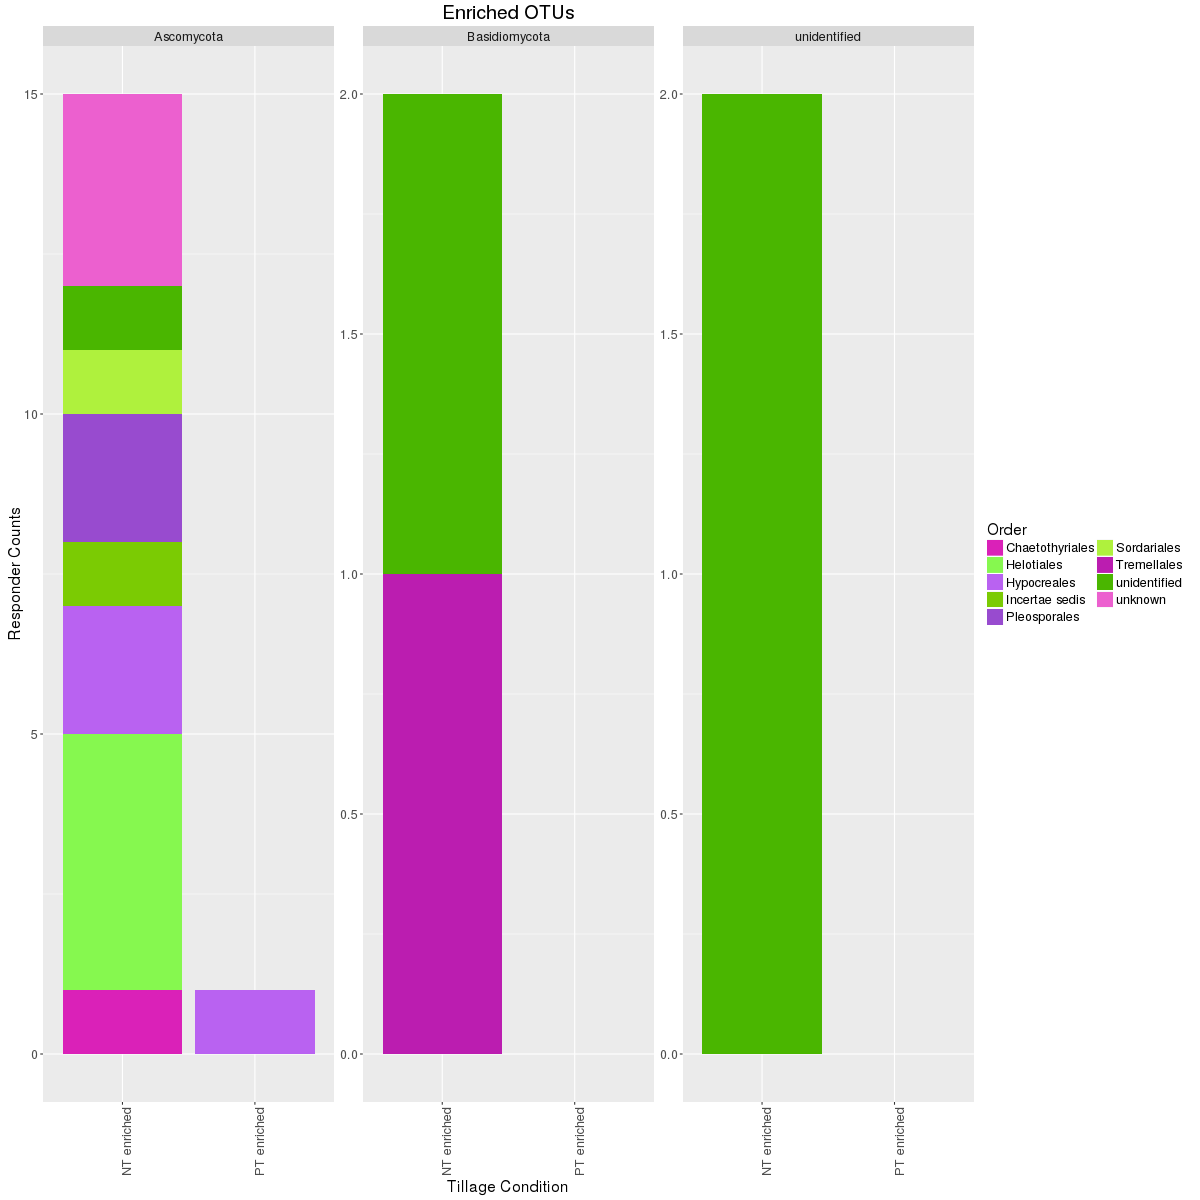

In [47]:
%%R -w 1200 -h 1200
dcounts = new_df.l2fc %>%
          filter(Resp_status %in% c("NT enriched", "PT enriched")) %>%
          group_by(OTU, Rank6, Rank5, Rank4, Rank3, Rank2, Resp_status) %>%
          summarize(responders = sum(padj2<= 0.10)) %>% ungroup() %>% arrange(Rank4)

dcounts$Rank4[is.na(dcounts$Rank4)] = "unknown"
dcounts$Rank5[is.na(dcounts$Rank5)] = "unknown"

dcounts$Rank4 = reorder(dcounts$Rank4, dcounts$Rank2)
#dcounts$Rank2 = reorder(dcounts$Rank2, -dcounts$responders)

p = ggplot(dcounts, aes(x = Resp_status , y = responders, fill = Rank4)) +
    geom_bar(stat = "identity") + #scale_x_discrete(breaks=NULL, name = NULL) +
    facet_wrap(~Rank2, scales = "free_y") +
    #scale_y_discrete(limits = (0, 50)) +
    ggtitle("Enriched OTUs") + ylab("Responder Counts")+
    xlab("Tillage Condition") + guides(fill=guide_legend(title='Order', ncol = 2)) +
    theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) +#, legend.position=c(2, 0.2)) +
    scale_fill_manual(values = colors.1)


p

In [48]:
%%R
dcounts%>% group_by(Rank4, Resp_status, Rank2) %>% select(Rank4, Rank2, responders, Resp_status) %>% 
                summarise(totresp = sum(responders)) %>% ungroup %>% arrange(Rank2) %>% as.data.frame

             Rank4 Resp_status         Rank2 totresp
1  Chaetothyriales NT enriched    Ascomycota       1
2       Helotiales NT enriched    Ascomycota       4
3      Hypocreales NT enriched    Ascomycota       2
4      Hypocreales PT enriched    Ascomycota       1
5   Incertae sedis NT enriched    Ascomycota       1
6     Pleosporales NT enriched    Ascomycota       2
7      Sordariales NT enriched    Ascomycota       1
8     unidentified NT enriched    Ascomycota       1
9          unknown NT enriched    Ascomycota       3
10     Tremellales NT enriched Basidiomycota       1
11    unidentified NT enriched Basidiomycota       1
12    unidentified NT enriched  unidentified       2


In [49]:
%%R
ggsave(filename = "data/figs/TillEnriched_byOrder.jpg", plot = p, width =20, height =14)

In [50]:
%%R
filter(dcounts, Rank2 == 'Cyanobacteria') %>% as.data.frame

[1] OTU         Rank6       Rank5       Rank4       Rank3       Rank2      
[7] Resp_status responders 
<0 rows> (or 0-length row.names)


In [51]:
%%R
length(unique(dcounts$Rank3))

[1] 6


In [52]:
%%R
colors = c("#F076F9",
"#3BF853",
"#8944B9",
"#93FB3B",
"#8C166F",
"#3CF397",
"#F63923",
"#2BFBD8",
"#B50F34",
"#7AF0EB",
"#D66E00",
"#579EFB",
"#A4CF32",
"#3E69C7",
"#E4F27B",
"#191D3B",
"#B2F8AB",
"#F15976",
"#38801A",
"#EE8BD6",
"#555415",
"#2F93C9",
"#EF8786",
"#142010",
"#F075AB",
"#0E4442",
"#F1B69C",
"#28507C",
"#CDCDE8")

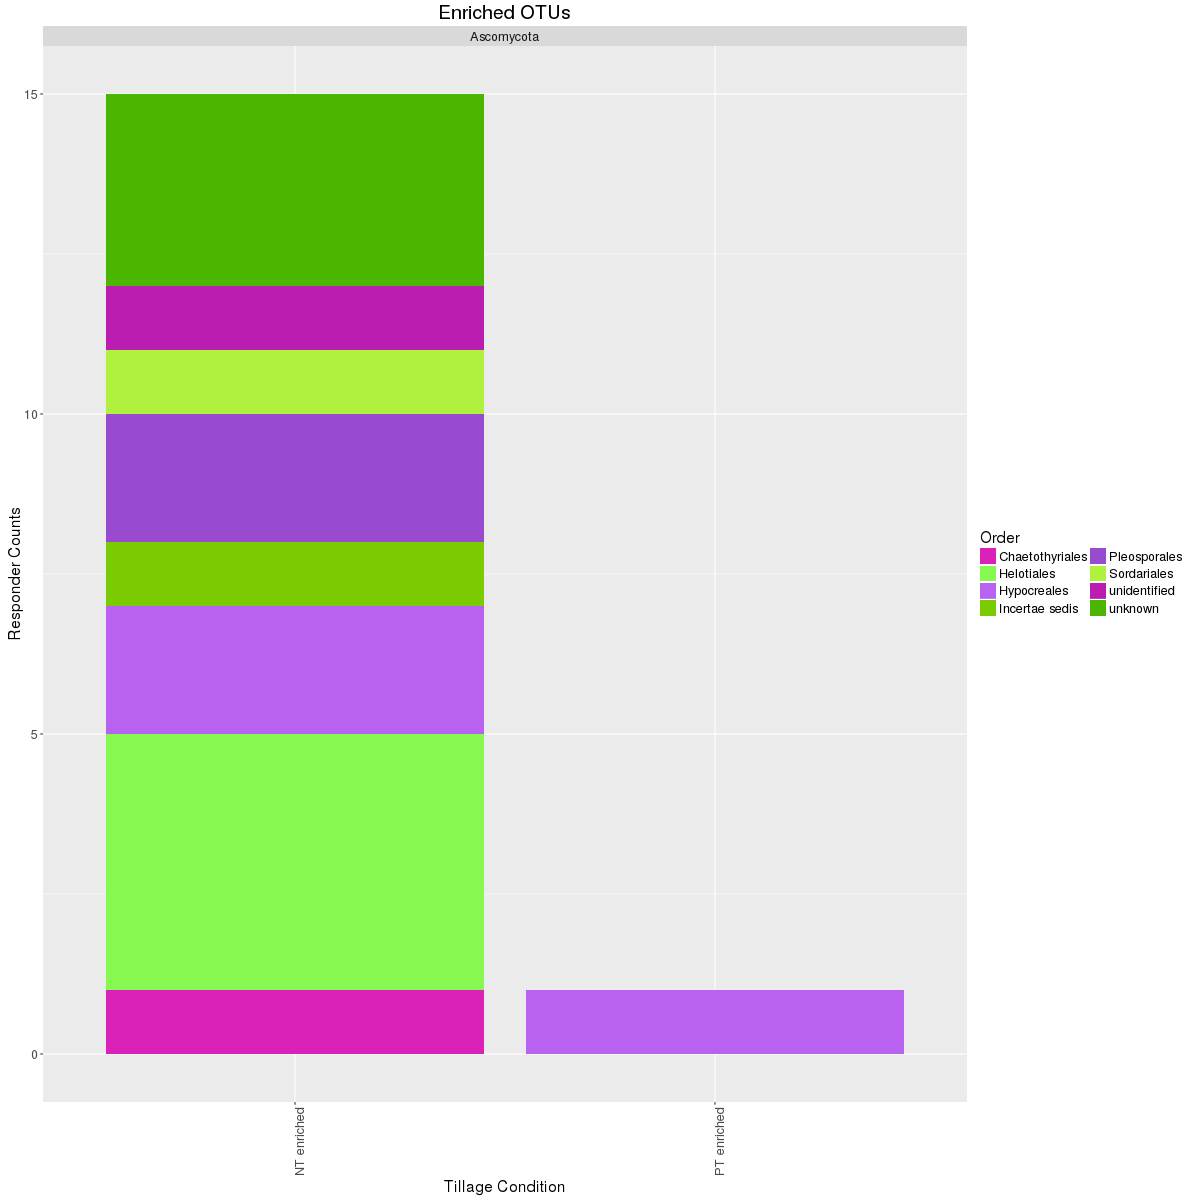

In [53]:
%%R -w 1200 -h 1200
Resp.to.keep = new_df.l2fc %>% group_by(Rank2, Resp_status) %>% summarise(Resp = sum(padj2<= 0.10)) %>% filter(Resp > 2)

dcounts.filt = filter(dcounts, Rank2 %in% Resp.to.keep$Rank2)

dcounts.filt$Rank3 = reorder(dcounts.filt$Rank3, -dcounts.filt$responders)
dcounts.filt$Rank2 = reorder(dcounts.filt$Rank2, -dcounts.filt$responders)


p = ggplot(dcounts.filt, aes(x = Resp_status , y = responders, fill = Rank4)) +
    geom_bar(stat = "identity") + #scale_x_discrete(breaks=NULL, name = NULL) +
    facet_wrap(~Rank2, scales = "free_y") +
    #scale_y_discrete(limits = (0, 50)) +
    ggtitle("Enriched OTUs") + ylab("Responder Counts")+
   xlab("Tillage Condition") + guides(fill=guide_legend(title='Order', ncol = 2)) +
    theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) +#, legend.position=c(2, 0.2)) +
    scale_fill_manual(values = colors.1)



p

In [54]:
%%R
ggsave(filename = "data/figs/TillEnriched_byOrder_filt.jpg", plot = p, width =20, height =14)

In [55]:
%%R
length(unique(d.counts.filt$Rank3))


Error in unique(d.counts.filt$Rank3) : object 'd.counts.filt' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in unique(d.counts.filt$Rank3) : object 'd.counts.filt' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In mean.default(X[[i]], ...) :
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning:  argument is not numeric or logical: returning NA

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 5: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarn

In [56]:
%%R
head(df.l2fc)

  Land_Management sparsity_threshold       OTU log2FoldChange      lfcSE
1             NTH                0.3   OTU.586    -0.27693388 0.12382706
2             NTH                0.3  OTU.1470     0.05747517 0.10478369
3             NTH                0.3   OTU.133    -0.01959796 0.06337634
4             NTH                0.3    OTU.45    -0.03424437 0.06585826
5             NTH                0.3  OTU.2583    -0.21611678 0.12034139
6             NTH                0.3 OTU.87670    -0.29031755 0.13302698
       padj    Rank1         Rank2           Rank3          Rank4
1 0.1139483 k__Fungi    Ascomycota Dothideomycetes           <NA>
2 0.8077015 k__Fungi Basidiomycota  Agaricomycetes     Agaricales
3 0.8965164 k__Fungi    Ascomycota Sordariomycetes    Hypocreales
4 0.8217570 k__Fungi Basidiomycota  Agaricomycetes    Polyporales
5 0.2270071 k__Fungi Basidiomycota  Agaricomycetes     Agaricales
6 0.1231637 k__Fungi    Zygomycota  Incertae sedis Mortierellales
            Rank5       Ran

In [57]:
%%R
new_df.l2fc = df.l2fc
new_df.l2fc$Resp_status[new_df.l2fc$padj2 <=0.10 & new_df.l2fc$log2FoldChange > 0] = 'T Enriched'
new_df.l2fc$Resp_status[new_df.l2fc$padj <= 0.10 & new_df.l2fc$log2FoldChange < 0] = 'NT Enriched'
new_df.l2fc$Resp_status[new_df.l2fc$padj > 0.10] = 'Not Enriched'



head(new_df.l2fc)

  Land_Management sparsity_threshold       OTU log2FoldChange      lfcSE
1             NTH                0.3   OTU.586    -0.27693388 0.12382706
2             NTH                0.3  OTU.1470     0.05747517 0.10478369
3             NTH                0.3   OTU.133    -0.01959796 0.06337634
4             NTH                0.3    OTU.45    -0.03424437 0.06585826
5             NTH                0.3  OTU.2583    -0.21611678 0.12034139
6             NTH                0.3 OTU.87670    -0.29031755 0.13302698
       padj    Rank1         Rank2           Rank3          Rank4
1 0.1139483 k__Fungi    Ascomycota Dothideomycetes           <NA>
2 0.8077015 k__Fungi Basidiomycota  Agaricomycetes     Agaricales
3 0.8965164 k__Fungi    Ascomycota Sordariomycetes    Hypocreales
4 0.8217570 k__Fungi Basidiomycota  Agaricomycetes    Polyporales
5 0.2270071 k__Fungi Basidiomycota  Agaricomycetes     Agaricales
6 0.1231637 k__Fungi    Zygomycota  Incertae sedis Mortierellales
            Rank5       Ran

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

  res = super(Function, self).__call__(*new_args, **new_kwargs)


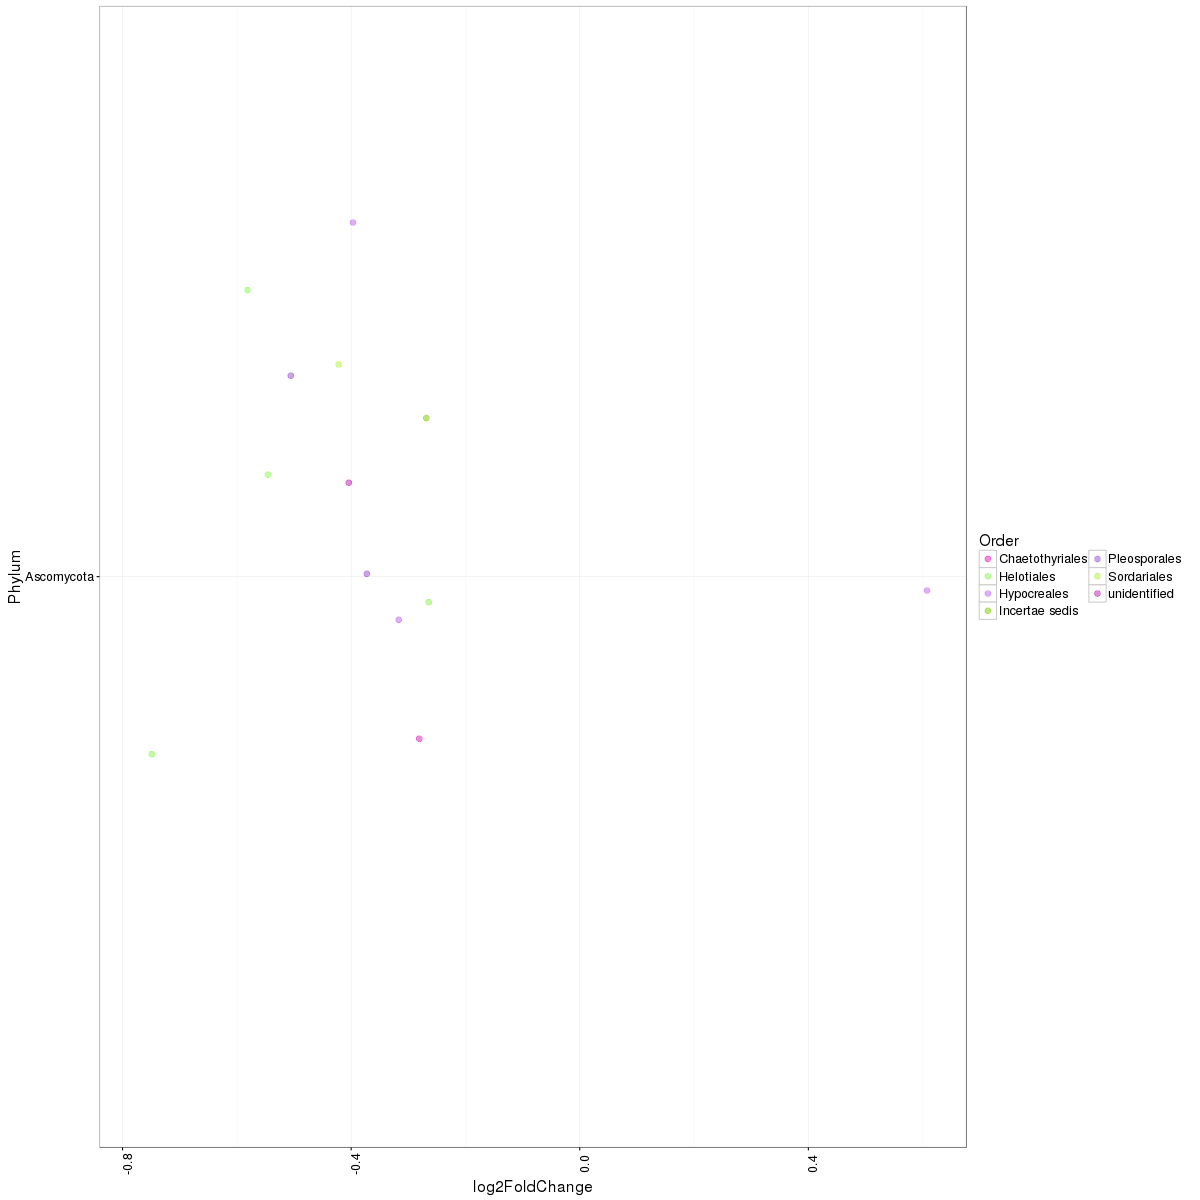

In [58]:
%%R -w 1200 -h 1200
d = filter(new_df.l2fc, padj2 <=0.10)#, 'Relative Abundance' > 0)
d = filter(d, Rank2 %in% dcounts.filt$Rank2)

p = ggplot(d, aes(log2FoldChange, Rank2))
p = p + geom_jitter(aes(color = Rank4), size = 2.5, height = 0.8, alpha = 0.5)
#p = p + facet_wrap(~Rank2, scales = 'free_y')
#p = p + xlab("RNA log2-fold change") + ylab("DNA log2-fold change")
p = p + scale_colour_discrete((name="Responder Status"))
p = p + ylab("Phylum") + theme_bw()

p = p + guides(color=guide_legend(title='Order', ncol = 2)) +
    theme(text = element_text(size=16), axis.text.x = element_text(angle=90, vjust=1)) +#, legend.position=c(2, 0.2)) +
    scale_color_manual(values = colors.1) 
p

In [59]:
%%R
ggsave(plot = p, filename = 'data/figs/l2fc_phylum_class.jpg', height = 14, width = 20)

In [60]:
%%R -w 600 -h 2000


phyla = unique((d.counts.filt$Rank2))

d = filter(new_df.l2fc, padj2 <=0.10)#, 'Relative Abundance' > 0)

plot = function(r, d) {
    plot.d = d %>% filter(Rank2 == r)
    #colors = scheme$hex(length(unique(plot.d$OTU)), color_space = hcl_presets$intense)

   p = ggplot(plot.d, aes(as.numeric(log2FoldChange), Rank3))
    p = p + geom_point(aes(color = Resp_status))
    p = p + scale_colour_discrete((name="Responder Status"))
    p = p + ylab("Class")
    p = p + theme_bw()
    p = p + xlim(-4, 6)
    
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9), axis.text.y  = element_text(angle=60, vjust=0.5, size=8)) 

        p = p + ggtitle(r)


    p}
    
plots.13CCPS = lapply(phyla, plot, d = d)

do.call(grid.arrange, c(plots.13CCPS,list(ncol=1)))


Error in unique((d.counts.filt$Rank2)) : object 'd.counts.filt' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in unique((d.counts.filt$Rank2)) : object 'd.counts.filt' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [61]:
%%R -w 600 -h 2000


phyla = unique((d.counts.filt$Rank2))

d = filter(new_df.l2fc, padj2 <=0.10)#, 'Relative Abundance' > 0)

plot = function(r, d) {
    plot.d = d %>% filter(Rank2 == r)
    #colors = scheme$hex(length(unique(plot.d$OTU)), color_space = hcl_presets$intense)

   p = ggplot(plot.d, aes(as.numeric(log2FoldChange), Rank3, fill = Rank4))
    p = p + geom_point()
    p = p + scale_colour_discrete((name="Responder Status"))
    p = p + ylab("Class")
    p = p + theme_bw()
    p = p + xlim(-4, 6)
    
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9), axis.text.x  = element_text(angle=90, vjust=0.5, size=10)) 

        p = p + ggtitle(r)


    p}
    
plots.13CCPS = lapply(phyla, plot, d = d)

do.call(grid.arrange, c(plots.13CCPS,list(ncol=1)))


Error in unique((d.counts.filt$Rank2)) : object 'd.counts.filt' not found
